In [6]:
# Imports
from iexfinance.stocks import Stock
import requests
import urllib.parse
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [7]:
# params
period = 'quarter'
time = '24'
symbol = ["ADBE","CRM"]
token = 'Tsk_910a8ace8ad14af698bc4a65be1a4219'
portfolio = {}
portfolio_det = {}

In [8]:
# get df from api

def get_df(ls, period, time, token):
    for ticker in ls:
        financials_url = f"https://sandbox.iexapis.com/stable/stock/{ticker}/financials?period={period}&last={time}&token={token}"
        financials_json = requests.get(financials_url).json()
        portfolio[ticker] = pd.DataFrame(financials_json['financials'])

In [9]:
def add_company(ls):
    for ticker in ls:
        company_url = f"https://sandbox.iexapis.com/stable/stock/{ticker}/company?token={token}"
        company_json = requests.get(company_url).json()
        portfolio_det[ticker] = pd.DataFrame(company_json)

In [10]:
# preprocessing

def preprocess(dic):
    for v in dic.values():
        v.rename(str.lower, axis='columns', inplace=True)
        v.set_index(pd.to_datetime(v['fiscaldate'].apply(lambda x: x[:7])), inplace=True)

In [11]:
# add columns

def add_profitability(dic):
    for df in dic.values():
        df['operating_margin'] = df['operatingincome'] / df['revenue']
        df['net_margin'] = df['netincome'] / df['revenue']
        df['asset_turnover'] = df['revenue'] / df['totalassets']
        df['roa'] = df['netincome']*4/ df['totalassets']
        df['equity_multipl'] = df['totalassets'] / df['shareholderequity']
        df['roe'] = df['netincome'] / df['shareholderequity']
        #df['fcf_margin'] = df['fcf'] / df['revenue']

def add_financial_strength(dic):
    for df in dic.values():
        df['cash_debt'] = df['totalcash'] / df['totaldebt']
        df['equity_asset'] = df['shareholderequity'] / df['totalassets']
        df['debt_equity'] = df['totaldebt'] / df['shareholderequity']
        df['debt_ebitda'] = df['totaldebt'] / (df['ebitda']*4)

In [16]:
# create graphs

def create_graphs(dic):
    for v in dic.values():
        fig, axes = plt.subplots(nrows=3, ncols=2)
        v[['revenue','netincome']].sort_index().plot(ax=axes[0,0], kind='bar',figsize=(20,20))
        v[['revenue','netincome']].sort_index().pct_change().plot(ax=axes[0,1],kind='line',figsize=(20,20))
        v[['operating_margin','net_margin']].sort_index().plot(ax=axes[1,0], kind='bar',figsize=(20,20))
        v[['operating_margin','net_margin']].sort_index().pct_change().plot(ax=axes[1,1], kind='line',figsize=(20,20))
        v[['roe','roa']].sort_index().plot(ax=axes[2,0], kind='bar',figsize=(20,20))
        v[['roe','roa']].sort_index().pct_change().plot(ax=axes[2,1], kind='line',figsize=(20,20))

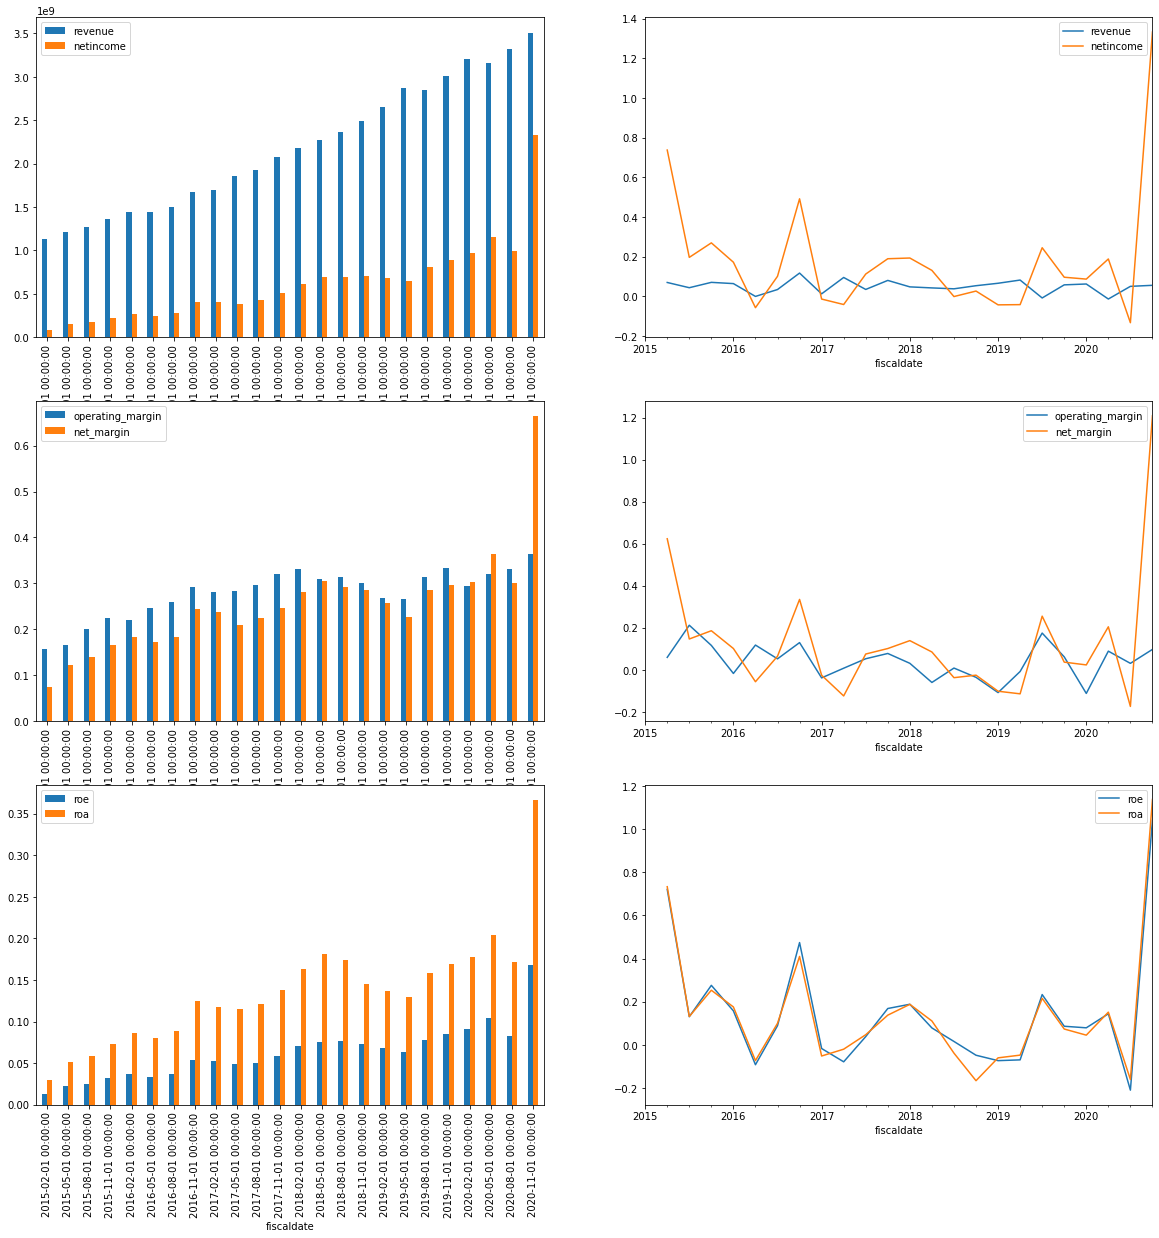

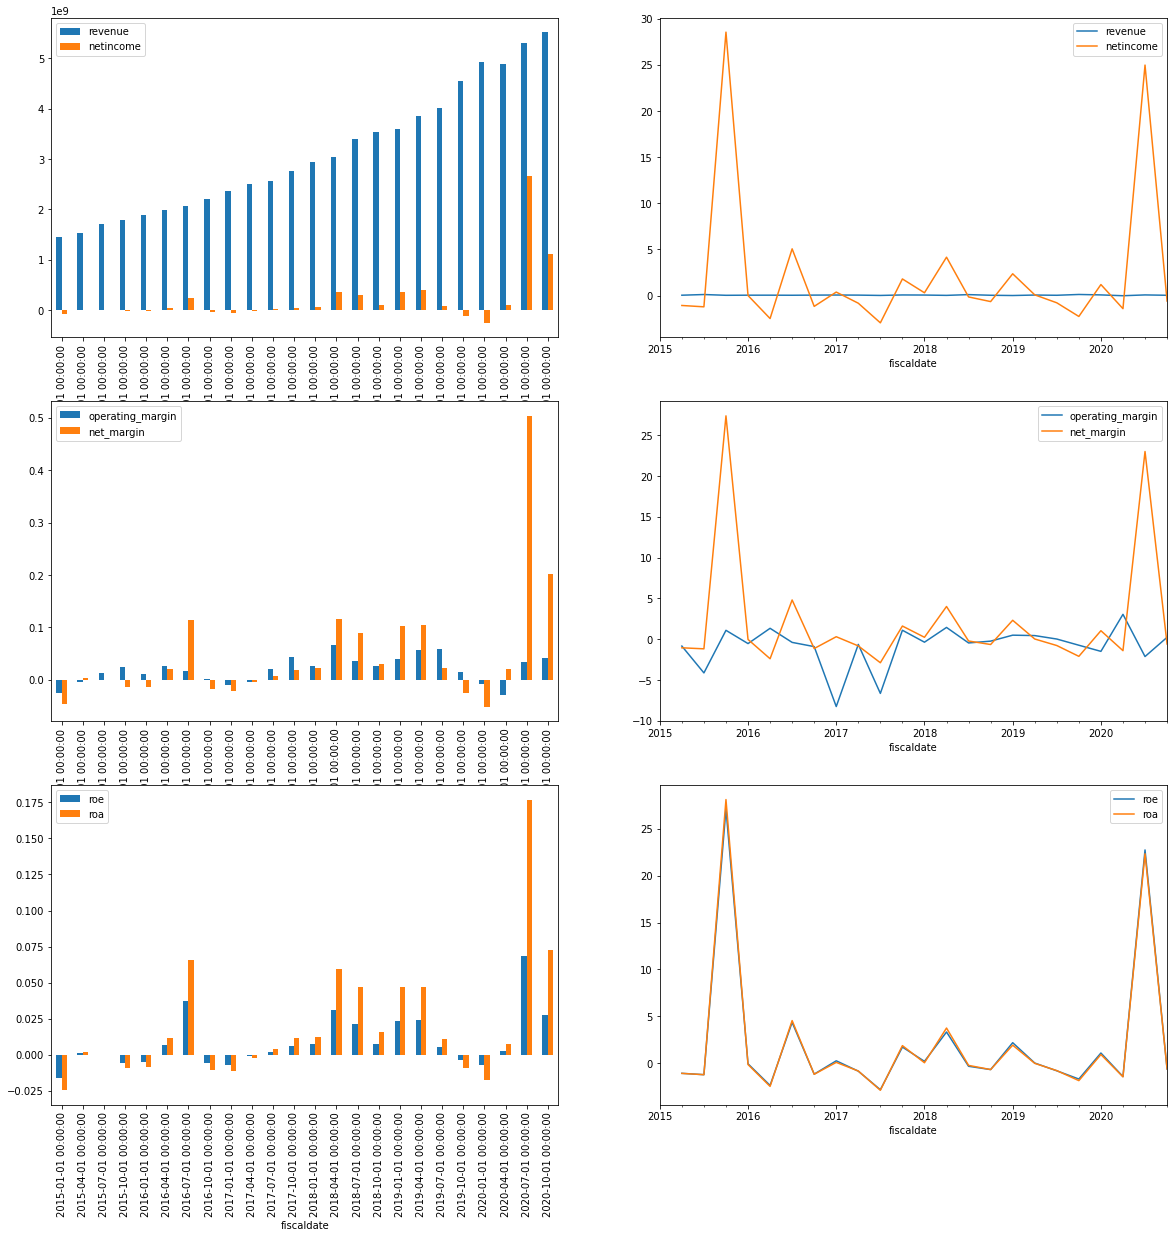

In [17]:
get_df(symbol, period, time, token)
add_company(symbol)
preprocess(portfolio)
add_profitability(portfolio)
add_financial_strength(portfolio)
create_graphs(portfolio)

In [ ]:
portfolio